# Synthetic Data com Serviços do OCI e SDV

Uma das tendências nos últimos anos, envolvendo dados e inteligência artificial, o termo “Synthetic Data” se refere ao dado que é produzido por meio de algoritmos para reproduzir as caracteristicas estatisticas do dado original.

Este é o primeiro de 2 artigos que abordam o assunto e tem por objetivo mostrar como podemos aplicar os conceitos de dados sintéticos com o uso de serviços de ETL e Data Science do OCI, atendendo requisitos de negócio, normas e legislação de segurança de dados, treinamento de algoritmos de machine learning entre outros.

Antes de entrarmos nos detalhes da construção, é muito importante tratarmos dos conceitos e necessidades de negócio que justificam a utilização de dados sintéticos.


## Casos de Uso

Existem diversas aplicações para o uso de dados sintéticos, mas normalmente elas estão associadas a duas situações: preciso de uma massa de dados maior, para treinamento dos algoritmos de ML ou preciso respeitar questões de segurança e privacidade de dados / questões regulatórias.

Ou não tenho dados suficientes para treinar os modelos de machine learning ou não tenho direito de acessar os dados, mesmo que seja para algum teste de hipótese ou experimento de data science.

A LGPD no Brasil e seus similares como a GPDR trazem a tona questões de privacidade de dados que podem ser auxiliadas com dados sintéticos. Se um cientista de dados precisa criar modelos ou realizar análise de dados, ele pode trabalhar em cima de dados onde as variáveis apresentam a mesma distribuição estatistica que o dado original.

Outro ponto, este velho conhecido de cientistas de dados e estatisticos, é o famoso dataset desbalanceado, onde as classes de interesse não apresentam a mesma proporção, o que acarreta grande risco de viés nos modelos. Veremos aqui que existem técnicas já bem conhecidas para tratar destas situações.

Teste de software é outro ponto que pode ser beneficiado com dados gerados por algoritmos, bem como simulações (exemplo, o caso da Oracle Red Bull Racing).

Na imagem abaixo, os sistemas produtivos continuariam acessando o banco de dados em azul, enquanto analistas, desenvolvedores e cientistas de dados podem trabalhar no banco sintético, em vermelho, sem prejuizo a suas atividades.

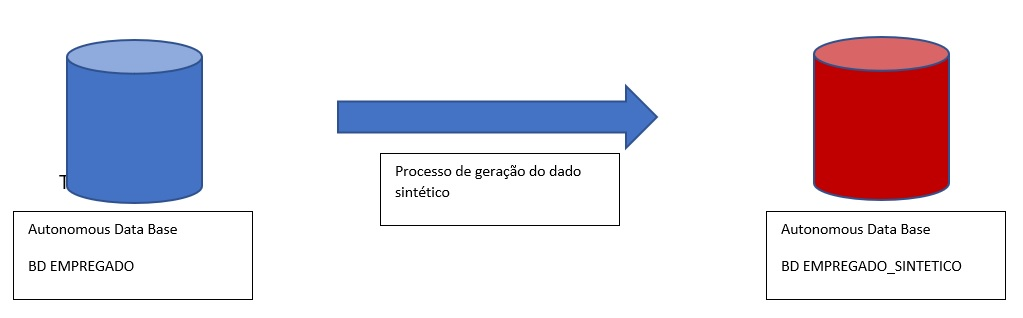

In [44]:
from IPython.display import display, Image
display(Image(filename='../Images/fluxobasico.jpg'))

Ressaltando que não estamos tratando apenas de dados tabulares. Também é possível gerar imagens artificiais para ajudar nos testes de veiculos autonomos por exemplo, ou em diversos filmes, onde rostos de atores já falecidos podem ser recriados com detalhes realisticos. 


## Conceitos

O dado sintético pode ser gerado a partir de dados reais, ou mesmo que não tenhamos os dados, desde que se saiba previamente as caracteristicas deste dado, distribuição estatistica, correlações, histórico, etc.

Imagine que precisamos avaliar o comportamento do cliente, mas o dado é de dificil acesso, por questões de segurança. Neste caso, podemos fazer uso do dado sintético, que não deveria ter tantas restrições e permissões necessárias, agilizando o processo.

Existe um indicador do quão o dado sintético simula o dado real, chamado de “Utility”.Quanto maior, mais próximo de simular o dado real está.

Outro ponto importante é que existe uma probabilidade de identificação do registro, e aqui estamos falando de privacidade de dados. Quanto maior esse indice de  privacidade de dados menor a utilidade, pois distorcemos as caracteristicas do dado.

É necessário portanto saber que haverá um trade-off entre esses dois indicadores e que dependendo do caso de uso posso escolher ter mais um do que o outro.

Teremos também um processo a ser implementado, para tratar estes dados e disponibilizá-los para consumo, o que deve ser parte de uma estratégia de Governança de Dados. Este processo deve respeitar algumas etapas:
- Leitura do dado de origem
- Preparação dos dados
- Sintese do dado
- Indicadores de qualidade

A idéia aqui é utilizar alguns serviços do OCI para criar um pipeline de dados sintéticos, em conjunto com bibliotecas open source. 


A arquitetura abaixo representa estas etapas e vamos falar um pouco delas mais para frente.

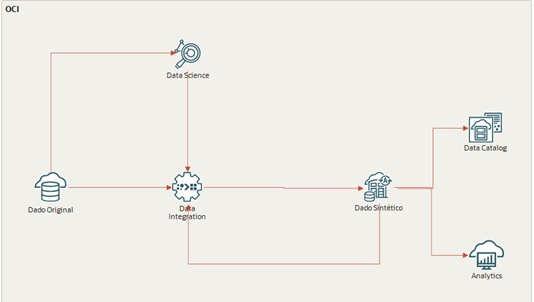

In [45]:
from IPython.display import display, Image
display(Image(filename='../Images/sint_arquitetura.jpg'))

Por enquanto, vamos nos focar em 2 etapas onde o apoio de um cientista de dados é muito importante: Preparação dos dados e Sintese dos dados.

Estas 2 etapas devem ser realizadas com auxilio de uma biblioteca open source chamada SDV e disponível para uso atráves da licença MIT. O site que descreve em detalhes essa biblioteca é o https://sdv.dev/SDV/index.html#

## SDV

O projeto do SDV se iniciou em 2016 dentro do MIT e evoluiu 4 anos depois para uma empresa chamada DataCebo que tem trabalhado sempre com o objetivo de evoluir este ecossistema de bibliotecas.

A biblioteca suporta diversos formatos de dados entre categóricos, numéricos, datetimes entre outros.

Antes de gerar os dados sintéticos, é necessário gerar um modelo do dado original e a biblioteca tem para isso modelos estatisticos e modelos baseados em deep learning. Para este exemplo utilizaremos um modelo estatistico denominado GaussianCopula.

Para desenvolver este exemplo vamos utilizar o serviço OCI Data Science, por permitir o desenvolvimento de modelos em Python e permitir também a criação de Jobs e modelos que podem entrar posteriormente em um ciclo de MLOPS e automação. 

O primeiro passo é importar a biblioteca sdv, via pip install e importar as classes que serão utilizadas neste exemplo, bem como a ADS do OCI (Acelerated Data Science)

In [46]:
#Instalação da biblioteca sdv
#! pip install sdv


In [47]:
#Instalação da biblioteca ADS (Acellerated Data Science)
#!pip install oracle-ads
#! pip install oracle-ads[geo]
#! pip install oracle-ads[data]
#! pip install --ignore-installed Pillow==9.0.0

In [48]:
#! pip install --ignore-installed Pillow==9.0.0

In [49]:
#Importação das bibliotecas do SDV
#from sdv.demo import load_tabular_demo
from sdv.sampling import Condition
#from sdv.tabular import CTGAN
from sdv.datasets.demo import download_demo
import ads
import pandas as pd
from ads.dataset.factory import DatasetFactory

import matplotlib.pyplot as plt

In [50]:
ads.hello()



  O  o-o   o-o
 / \ |  \ |
o---o|   O o-o
|   ||  /     |
o   oo-o  o--o

ads v2.8.10
oci v2.112.4
ocifs v1.1.3




In [51]:
connection_parameters = {
    "user_name": "ADMIN",
    "password": "343434@@",
    "service_name": "dbadwtest1_low",
    "wallet_location": "../Wallet_DBADWTEST1.zip",
}

In [52]:
data = pd.DataFrame.ads.read_sql(
    "SELECT * FROM ADMIN.STUDENT_PLACEMENTS",
    connection_parameters=connection_parameters,
)

In [54]:
data.head(5)

,STUDENT_ID,ADDRESS,GENDER,SECOND_PERC,HIGH_PERC,HIGH_SPEC,DEGREE_PERC,DEGREE_TYPE,WORK_EXPERIENCE,EXPERIENCE_YEARS,EMPLOYABILITY_PERC,MBA_SPEC,MBA_PERC,SALARY,PLACED,START_DATE,END_DATE,DURATION
0,17264,"70304 Baker Turnpike\nEricborough, MS 15086",M,67.00,91.00,Commerce,58.00,Sci&Tech,False,0,55.0,Mkt&HR,58.80,27000.0,True,None,None,3.0
1,17265,"805 Herrera Avenue Apt. 134\nMaryview, NJ 36510",M,79.33,78.33,Science,77.48,Sci&Tech,True,1,86.5,Mkt&Fin,66.28,20000.0,True,None,None,3.0
2,17266,"3702 Bradley Island\nNorth Victor, FL 12268",M,65.00,68.00,Arts,64.00,Comm&Mgmt,False,0,75.0,Mkt&Fin,57.80,25000.0,True,None,None,6.0
3,17267,Unit 0879 Box 3878\nDPO AP 42663,M,56.00,52.00,Science,52.00,Sci&Tech,False,0,66.0,Mkt&HR,59.43,NaN,False,None,None,NaN
4,17268,"96493 Kelly Canyon Apt. 145\nEast Steven, NC 35475",M,85.80,73.60,Commerce,73.30,Comm&Mgmt,False,0,96.8,Mkt&Fin,55.50,42500.0,True,None,None,3.0


Tendo importado as bibliotecas, podemos efetuar a leitura dos dados de origem. No nosso exemplo, estes dados serão acessados via pois estão na tabela TB_EMPREGADOS de um Autonomous Data Base.

In [55]:
#Leitura do dado de origem
#data = load_tabular_demo('student_placements_pii')

Vamos efetuar uma breve avaliação do tipo de dado disponível e sua natureza. Para tanto podemos utilizar a biblioteca ADS do OCI Data Science que nos permite entender as principais caractisticas de nosso dataset.

In [56]:
ds = DatasetFactory.from_dataframe(data)

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

In [57]:
ds.show_in_notebook()

Accordion(children=(HTML(value='<h1>Name: User Provided DataFrame</h1><h3>Type: ADSDataset</h3><h3>215 Rows, 1…

Podemos notar que algumas linhas estão com variáveis nulas, como por exemplo Salary e Duration. Aqui os fundamentos não são diferentes. Precisamos tratar dados nulos ou outliers pois eles influenciam nas estatisticas e consequentemente na sintetização do dado posteriormente.


Salary é uma coluna importante dentro do contexto do negócio  que estamos tratando no exemplo então vamos preencher ela com a mediana. Para não simplificar demais, utilizamos a mediana agrupada pela coluna degree_type, mas outros valores poderiam entrar nesse agrupamento para melhor representar o dado que estamos inputando como por exemplo, genero, tempo de experiência e outras variáveis.

In [58]:
data['SALARY'] = data['SALARY'].fillna(data.groupby('DEGREE_TYPE')['SALARY'].transform('median'))


In [59]:
data.describe()

,STUDENT_ID,SECOND_PERC,HIGH_PERC,DEGREE_PERC,EXPERIENCE_YEARS,EMPLOYABILITY_PERC,MBA_PERC,SALARY,DURATION
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,148.000000
mean,17371.000000,67.303395,66.333163,66.370186,0.390698,72.100558,62.278186,28075.813953,5.331081
std,62.209324,10.827205,10.897509,7.358743,0.584781,13.275956,5.833385,7845.647115,3.279266
min,17264.000000,40.890000,37.000000,50.000000,0.000000,50.000000,51.210000,20000.000000,3.000000
25%,17317.500000,60.600000,60.900000,61.000000,0.000000,60.000000,57.945000,25000.000000,3.000000
50%,17371.000000,67.000000,65.000000,66.000000,0.000000,71.000000,62.000000,26000.000000,3.000000
75%,17424.500000,75.700000,73.000000,72.000000,1.000000,83.500000,66.255000,28250.000000,6.000000
max,17478.000000,89.400000,97.700000,91.000000,3.000000,98.000000,77.890000,94000.000000,12.000000


In [60]:
data.head()

,STUDENT_ID,ADDRESS,GENDER,SECOND_PERC,HIGH_PERC,HIGH_SPEC,DEGREE_PERC,DEGREE_TYPE,WORK_EXPERIENCE,EXPERIENCE_YEARS,EMPLOYABILITY_PERC,MBA_SPEC,MBA_PERC,SALARY,PLACED,START_DATE,END_DATE,DURATION
0,17264,"70304 Baker Turnpike\nEricborough, MS 15086",M,67.00,91.00,Commerce,58.00,Sci&Tech,False,0,55.0,Mkt&HR,58.80,27000.0,True,None,None,3.0
1,17265,"805 Herrera Avenue Apt. 134\nMaryview, NJ 36510",M,79.33,78.33,Science,77.48,Sci&Tech,True,1,86.5,Mkt&Fin,66.28,20000.0,True,None,None,3.0
2,17266,"3702 Bradley Island\nNorth Victor, FL 12268",M,65.00,68.00,Arts,64.00,Comm&Mgmt,False,0,75.0,Mkt&Fin,57.80,25000.0,True,None,None,6.0
3,17267,Unit 0879 Box 3878\nDPO AP 42663,M,56.00,52.00,Science,52.00,Sci&Tech,False,0,66.0,Mkt&HR,59.43,27500.0,False,None,None,NaN
4,17268,"96493 Kelly Canyon Apt. 145\nEast Steven, NC 35475",M,85.80,73.60,Commerce,73.30,Comm&Mgmt,False,0,96.8,Mkt&Fin,55.50,42500.0,True,None,None,3.0


Na amostra de dados não existem dados que podemos considerar como outliers então não faremos ajustes neste caso.

Um ponto importantissimo é prestarmos atenção nos dados, para ver se por exemplo não existem dados que devam ser preenchidos de maneira deterministica. Aqui mesmo temos um exemplo, que são as datas de inicio, fim e a duração.

A duração está diretamente ligada às variáveis start_date e end_date. Ela deve ser imputada como resultado da subtração das 2 variáveis e não por meio de valores aleatórios gerados pelo SDV. Um exemplo do quão importante é começar entendedo o processo do cliente e suas regras.

Poderiamos adotar uma start_date para os campos nulos, e calcular a end_date com base no valor mediano da variável duration.

Algo parecido teriamos se tivesse uma variável chamada IMC... indice de massa corporea... é um cálculo e não posso atribuir valores aleatórios.

A biblioteca DSV também permite sinalizar quais campos devemos anonimizar. Variáveis como endereço ou nome devem ser anonimizadas e utilizamos um parametro chamado anonymize_fields para informar quais são essas variáveis.

Variáveis que são chaves primárias também podem ser tratadas de maneira a não serem tratadas de maneira estatistica pela biblioteca. O parametro primary_key abaixo trata desta informação.

### Obter os metadados do dataset

In [61]:

from sdv.metadata import SingleTableMetadata


In [62]:
metadata = SingleTableMetadata()

In [63]:
metadata.detect_from_dataframe(data)

In [64]:
metadata_dict = metadata.to_dict()

### Instanciar o sintetizador

In [65]:
from sdv.single_table import CTGANSynthesizer

synthesizer = CTGANSynthesizer(metadata)
synthesizer.fit(data)

Tendo criado o modelo e efetuado o treinamento, podemos gerar uma amostra, do tamanho que desejarmos.

In [67]:
new_data = synthesizer.sample(num_rows=215)

In [68]:
new_data.head()

,STUDENT_ID,ADDRESS,GENDER,SECOND_PERC,HIGH_PERC,HIGH_SPEC,DEGREE_PERC,DEGREE_TYPE,WORK_EXPERIENCE,EXPERIENCE_YEARS,EMPLOYABILITY_PERC,MBA_SPEC,MBA_PERC,SALARY,PLACED,START_DATE,END_DATE,DURATION
0,215,sdv-pii-zeldq,M,63.48,60.58,Commerce,63.41,Others,False,1,98.00,Mkt&Fin,71.83,27295.0,True,NaN,NaN,NaN
1,216,sdv-pii-zub4w,M,77.14,51.27,Science,78.08,Comm&Mgmt,False,0,80.40,Mkt&HR,61.76,27014.0,False,NaN,NaN,NaN
2,217,sdv-pii-3lzv9,M,54.81,56.76,Science,84.51,Comm&Mgmt,True,2,83.79,Mkt&Fin,51.21,22726.0,True,NaN,NaN,12.0
3,218,sdv-pii-wcbrk,M,88.05,61.66,Science,86.68,Comm&Mgmt,False,0,98.00,Mkt&HR,59.32,29275.0,False,NaN,NaN,3.0
4,219,sdv-pii-hiss8,M,74.33,72.87,Science,79.75,Comm&Mgmt,False,0,54.28,Mkt&Fin,77.89,29511.0,False,NaN,NaN,3.0


In [69]:
new_data.describe()

,STUDENT_ID,SECOND_PERC,HIGH_PERC,DEGREE_PERC,EXPERIENCE_YEARS,EMPLOYABILITY_PERC,MBA_PERC,SALARY,DURATION
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,141.000000
mean,322.000000,66.390791,60.504605,69.146186,0.427907,82.039209,64.058140,27434.655814,5.489362
std,62.209324,13.742677,12.779244,10.273107,0.636259,13.045966,7.554957,7101.345489,3.475664
min,215.000000,40.890000,37.000000,50.000000,0.000000,50.000000,51.210000,20000.000000,3.000000
25%,268.500000,56.410000,52.570000,61.985000,0.000000,72.960000,58.040000,22733.000000,3.000000
50%,322.000000,66.690000,59.510000,68.530000,0.000000,81.430000,63.180000,25812.000000,3.000000
75%,375.500000,75.535000,67.690000,76.965000,1.000000,96.930000,69.525000,29590.000000,6.000000
max,429.000000,89.400000,97.700000,91.000000,3.000000,98.000000,77.890000,57497.000000,12.000000


A biblioteca permite que possamos salvar o modelo obtido, em formato ,pkl, conforme mostrado abaixo.

Vamos utilizar esta funcionalidade em um próximo artigo, pensando na automação do processo de forma a utilizar este modelo em um processo de ETL.

In [70]:
synthesizer.save('my_model.pkl')

Fazendo o caminho reverso, podemos carregar o modelo novamente e gerar uma amostra com o método sample.

In [71]:
loaded_model = synthesizer.load('my_model.pkl')

In [72]:
new_data = loaded_model.sample(num_rows=215)

In [73]:
new_data.describe()

,STUDENT_ID,SECOND_PERC,HIGH_PERC,DEGREE_PERC,EXPERIENCE_YEARS,EMPLOYABILITY_PERC,MBA_PERC,SALARY,DURATION
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,148.000000
mean,537.000000,64.926977,60.808233,68.577860,0.390698,83.145767,64.521767,27683.525581,5.290541
std,62.209324,14.256607,12.151115,10.442512,0.592718,13.321656,7.516485,7765.280635,3.399186
min,430.000000,40.890000,37.000000,50.000000,0.000000,50.770000,51.210000,20000.000000,3.000000
25%,483.500000,53.455000,52.570000,60.495000,0.000000,74.430000,58.800000,22502.000000,3.000000
50%,537.000000,64.250000,61.270000,68.840000,0.000000,82.850000,64.840000,26228.000000,3.000000
75%,590.500000,76.620000,67.945000,76.190000,1.000000,98.000000,69.820000,29200.500000,6.000000
max,644.000000,89.400000,97.700000,90.980000,2.000000,98.000000,77.890000,59936.000000,12.000000


Podemos visualizar variáveis de interesse por meio de histogramas e comparar o dataset gerado contra o dataset original. Esta é uma maneira de visualizar o quão o dado sintético simula a realidade.

## Evaluation

Tão importante quanto gerar o dado sintético e verificar se ele representa bem o dado, não apenas no momento em que é gerado quanto ao longo do tempo. Eventuais ajustes ao longo do tempo podem ser necessários.

O pacote SDV vem com métodos para gerar relatórios sobre a qualidade do dado sintético. Como são vários, vou apresentar alguns aqui.

Vamos começar importando a biblioteca sdmetrics e recuperando os metadados do dataset
Aqui vamos confrontar dados sintético com o dado real, com relação à variável salary.

In [37]:
from sdv.evaluation.single_table import get_column_plot
from sdmetrics.reports.single_table import QualityReport
from sdmetrics.reports import utils


In [74]:

fig = get_column_plot(
    real_data=data,
    synthetic_data=new_data,
    column_name='SALARY',
    metadata=metadata
)
    
fig.show()

Aqui fazemos o mesmo em relação à variável EXPERIENCE_YEARS.

In [75]:

fig = get_column_plot(
    real_data=data,
    synthetic_data=new_data,
    column_name='EXPERIENCE_YEARS',
    metadata=metadata
)

fig.show()

Parece OK para o nosso exemplo, mas podemos obter algumas outras medidas para comparação. Podemos ter um score geral para o dataset sintético, conforme abaixo:

In [40]:
report = QualityReport()

In [41]:
report.generate(data, new_data,metadata_dict  )

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 153/153 [00:01<00:00, 109.72it/s]

Overall Score: 73.15%

Properties:
- Column Shapes: 86.12%
- Column Pair Trends: 60.17%


Para finalizar, podemos comparar a correlação entre as variáveis no dataset real e no dataset sintético, bem como verificar visualmente a similaridade entre os dados reais e os sintéticos.

In [42]:
report.get_visualization(property_name='Column Pair Trends')

## Conclusão

Este artigo é a primeira parte de 2, e aborda o trabalho análitico necessário para gerar um dataset sintético, utilizando serviços do OCI e bibliotecas open source.

A biblioteca SDV é muito ampla e abordei uma pequena parte aqui. Existem diversos algoritmos que podem ser utilizados para sintetizar dados e diversos tipos de distribuição que podem ser testadas no processo. Recomendo aos interessados no assunto estudar a biblioteca pelo site da biblioteca, buscar livros para entender bem o conceito e testar bastante. É um trabalho conjunto entre cientistas de dados, engenheiros de dados e responsáveis por segurança e governança.

https://sdv.dev/SDV/index.html#

Todo o trabalho aqui foi conduzido no OCI Data Science que é uma plataforma voltada para o cientista de dados, completa, com suporte a MLOPs, escalável e baseada em JupyterLabs. 

https://www.oracle.com/br/artificial-intelligence/data-science/

Na segunda parte, vamos automatizar este processo criando um pipeline para geração de dados sintéticos.